In [2]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

C:\Users\SRIKANTH\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt' # used data for the listen count
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'# used for fields like artist name,song name ,etc

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

 # Load music data

# Explore data
Music data shows how many times a user listened to a song, as well as the details of the song.

In [5]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


## Length of the dataset

In [8]:
len(song_df)

2000000

In [9]:
song_df.shape

(2000000, 7)

## Create a subset of the dataset

In [8]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

C:\Users\SRIKANTH\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
song_df.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly - Foo Fighters


## Showing the most popular songs in the dataset

In [10]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5139,high fives - Four Tet,1,0.01
5140,in white rooms - Booka Shade,1,0.01
5143,paranoid android - Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


## Count number of unique users in the dataset

In [25]:
users = song_df['user_id'].unique()
len(users)

365

## Quiz 1. Count the number of unique songs in the dataset

In [26]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

In [35]:
a=pandas.DataFrame()
for i in range(0,5152):
    if i==0:
        a['users']=users
    else:
        a[]      

,users
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e
1,85c1f87fea955d09b4bec2e36aee110927aedf9a
2,bd4c6e843f00bd476847fb75c47b4fb430a06856
3,8937134734f869debcab8f23d77465b4caaa85df
4,969cc6fb74e076a68e36a04409cb9d3765757508
...,...
360,b923c4fc244d671f96ede79a60b10da1583ddab2
361,ba8d1693c3c2153d4eb7952c786c575c1c68cc55
362,bf03bbb01a7803ed1a5fec51bfe9423a79737d1a
363,08c129083a44492415e40b70d8f90755e15f4a91


# Create a song recommender

In [15]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

## Simple popularity-based recommender class (Can be used as a black box)

In [ ]:
#Recommenders.popularity_recommender_py # popularity_recommender_py -- it is a class in the file Recommenders , just like instance to the class

### Create an instance of popularity based recommender class

In [16]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Use the popularity model to make some predictions

In [69]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [18]:
###Fill in the code here
user_id = users[8]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## Build a song recommender with personalization

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

## Class for an item similarity based personalized recommender system (Can be used as a black box)

### Create an instance of item similarity based recommender class

In [19]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Use the personalized model to make some song recommendations

In [20]:
users

array(['b80344d063b5ccb3212f76538f3d9e43d87dca9e',
       '85c1f87fea955d09b4bec2e36aee110927aedf9a',
       'bd4c6e843f00bd476847fb75c47b4fb430a06856',
       '8937134734f869debcab8f23d77465b4caaa85df',
       '969cc6fb74e076a68e36a04409cb9d3765757508',
       '4bd88bfb25263a75bbdd467e74018f4ae570e5df',
       'e006b1a48f466bf59feefed32bec6494495a4436',
       '9d6f0ead607ac2a6c2460e4d14fb439a146b7dec',
       '9bb911319fbc04f01755814cb5edb21df3d1a336',
       'b64cdd1a0bd907e5e00b39e345194768e330d652',
       '17aa9f6dbdf753831da8f38c71b66b64373de613',
       'd6589314c0a9bcbca4fee0c93b14bc402363afea',
       '5a905f000fc1ff3df7ca807d57edb608863db05d',
       'c737ec8c1b16ce8e39115f4432c9a7fc21ec47a1',
       '45544491ccfcdc0b0803c34f201a6287ed4e30f8',
       'ed7d4c476013b1c3dd91982b61494bf7436083ba',
       'baf47ed8da24d607e50d8684cde78b923538640f',
       '169f9f4c68b62d1887c7c0ac99d10a79cfca5daf',
       'a820d2d4f16bbd53be9e41e0417dfb234bfdfba8',
       'bd8475385f0aa78830fa6df

In [21]:
song_df[song_df['user_id']==users[4]]

,user_id,song_id,listen_count,title,release,artist_name,year,song
56,969cc6fb74e076a68e36a04409cb9d3765757508,SOABRAB12A6D4F7AAF,2,A Pain That Im Used To,Playing The Angel,Depeche Mode,2005,A Pain That Im Used To - Depeche Mode
57,969cc6fb74e076a68e36a04409cb9d3765757508,SOAOQFD12A6D4FAAA9,1,Medicating,Trainwreck,Boys Night Out,2005,Medicating - Boys Night Out
58,969cc6fb74e076a68e36a04409cb9d3765757508,SOBFPJC12A58A7D1AB,9,Crystal Blue Persuasion,Anthology,Tommy James And The Shondells,1968,Crystal Blue Persuasion - Tommy James And The ...
59,969cc6fb74e076a68e36a04409cb9d3765757508,SOBZZDU12A6310D8A3,2,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986,Don't Dream It's Over - Crowded House
60,969cc6fb74e076a68e36a04409cb9d3765757508,SODCNJX12A6D4F93CB,2,Jamaica Roots II(Agora E Sempre),Nova Bis-Natiruts,Natiruts,0,Jamaica Roots II(Agora E Sempre) - Natiruts
61,969cc6fb74e076a68e36a04409cb9d3765757508,SOERVXG12A6D4F5583,1,Besame Mucho,The Best of Andrea Bocelli - 'Vivere',Andrea Bocelli,2006,Besame Mucho - Andrea Bocelli
62,969cc6fb74e076a68e36a04409cb9d3765757508,SOFXZAW12A67ADC90E,1,Groovin' (LP Version),Stax/Volt - The Complete Singles 1959-1968 - V...,Booker T. & The MG's,0,Groovin' (LP Version) - Booker T. & The MG's
63,969cc6fb74e076a68e36a04409cb9d3765757508,SOGFUFC12A8C13F1E5,6,It's My Party,1960's School Party Night,Lesley Gore,1963,It's My Party - Lesley Gore
64,969cc6fb74e076a68e36a04409cb9d3765757508,SOLVRLL12A67020D7F,2,Eminence Front,The Who - Ultimate Collection,The Who,1982,Eminence Front - The Who
65,969cc6fb74e076a68e36a04409cb9d3765757508,SONQEYS12AF72AABC9,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows,1991,Mr. Jones - Counting Crows


In [22]:
#Print the songs for the user in training data
user_id = users[4]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 969cc6fb74e076a68e36a04409cb9d3765757508:
------------------------------------------------------------------------------------
Heartbreak Warfare - John Mayer
Mr. Jones - Counting Crows
Groovin'  (Single Version) - The Young Rascals
Found Home - 59 Times the Pain
All My Friends - LCD Soundsystem
The Waiting - Tom Petty And The Heartbreakers
A Pain That Im Used To - Depeche Mode
You Get What You Give - New Radicals
Don't Dream It's Over - Crowded House
Eminence Front - The Who
Medicating - Boys Night Out
Crystal Blue Persuasion - Tommy James And The Shondells
Besame Mucho - Andrea Bocelli
Reasons - Minnie Riperton
We Don't Stop (Explicit) - Young Bleed
Who's Real - Jadakiss / Swizz Beatz / OJ Da Juiceman
Jamaica Roots II(Agora E Sempre) - Natiruts
Groovin'  (LP Version) - Booker T. & The MG's
It's My Party - Lesley Gore
------------------------------------------

,user_id,song,score,rank
0,969cc6fb74e076a68e36a04409cb9d3765757508,Move Away - The Killers,0.04386,1
1,969cc6fb74e076a68e36a04409cb9d3765757508,Broken Face - Pixies,0.04386,2
2,969cc6fb74e076a68e36a04409cb9d3765757508,Ask - The Smiths,0.04386,3
3,969cc6fb74e076a68e36a04409cb9d3765757508,Never Miss A Beat - Kaiser Chiefs,0.04386,4
4,969cc6fb74e076a68e36a04409cb9d3765757508,State Of Love And Trust - Pearl Jam,0.04386,5
5,969cc6fb74e076a68e36a04409cb9d3765757508,Under The Falling Sky (LP Version) - Jackson B...,0.04386,6
6,969cc6fb74e076a68e36a04409cb9d3765757508,Nostalgia - The Long Blondes,0.04386,7
7,969cc6fb74e076a68e36a04409cb9d3765757508,The Killing Moon - Echo And The Bunnymen,0.04386,8
8,969cc6fb74e076a68e36a04409cb9d3765757508,Sweet Talk - The Killers,0.04386,9
9,969cc6fb74e076a68e36a04409cb9d3765757508,Sam's Town - The Killers,0.04386,10


### Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [23]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


### We can also apply the model to find similar songs to any song in the dataset

In [24]:
is_model.get_similar_items(['U Smile - Justin Bieber']) # to predict similar songs as like justin Bieber

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1
1,,Bad Company - Five Finger Death Punch,0.375000,2
2,,Love Me - Justin Bieber,0.333333,3
3,,One Time - Justin Bieber,0.333333,4
4,,Here Without You - 3 Doors Down,0.333333,5
5,,Stuck In The Moment - Justin Bieber,0.333333,6
6,,Teach Me How To Dougie - California Swag District,0.333333,7
7,,Paper Planes - M.I.A.,0.333333,8
8,,Already Gone - Kelly Clarkson,0.333333,9
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10


### Quiz 4. Use the personalized recommender model to get similar songs for the following song.

In [25]:
song = 'Yellow - Coldplay'
###Fill in the code here
is_model.get_similar_items([song]) # similarity to coldplay song based on purchased history

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


# Quantitative comparison between the models

We now formally compare the popularity and the personalized models using precision-recall curves. 

## Class to calculate precision and recall (This can be used as a black box)

In [ ]:
#Evaluation.precision_recall_calculator
# all the relevent set from the test set and all the set generate by the model from the train set # that  we will calculate

## Use the above precision recall calculator class to calculate the evaluation measures

In [46]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:e4b02864403d483586cd9c8ed6b9bfae56fe8bc1
No. of unique songs for the user: 9
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :504
Getting recommendations for user:3fd3acaa8dfeb94b0602a33085b44ebe80545dd2
No. of unique songs for the user: 38
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :4617
Getting recommendations for user:529b42cdbc379ad2e765aec6d3bad8a192038741
No. of unique songs for the user: 45
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :6764
Getting recommendations for user:c5d42aa00afa6889de703c49f40ecb26b1c401c4
No. of unique songs for the user: 36
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2994
Getting recommendations for user:3851d01aa9d1b2505fa361b63940e8cdc9a3e754
No. of unique songs for the user: 21
no. of unique songs in th

## Code to plot precision recall curve

In [27]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


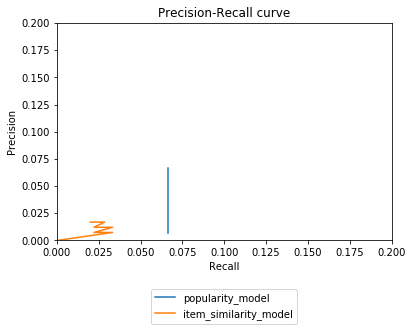

In [28]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Generate Precision Recall curve using pickled results on a larger data subset(Python 3)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


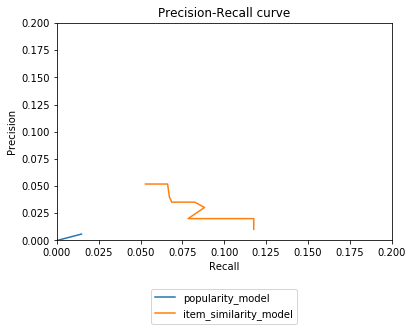

In [47]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

The curve shows that the personalized model provides much better performance over the popularity model. 

# Matrix Factorization based Recommender System

### Import the required libraries

In [53]:
import math as mt
import csv
import numpy as np
from scipy.sparse import csc_matrix #used for sparse matrix
from scipy.sparse.linalg import * #used for matrix multiplication
from sparsesvd import sparsesvd #used for matrix factorization
#Note: You may need to install the library sparsesvd.
# SVD- Singular Value Decomposition

# Methods to compute SVD and recommendations

In [54]:
#constants defining the dimensions of our User Rating Matrix (URM)
MAX_PID = 4
MAX_UID = 5

#Compute SVD of the user ratings matrix
def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the indices 
        #of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom

# Use SVD to make predictions for a test user id, say 4

In [66]:
#Used in SVD calculation (number of latent factors)
K=2

#Initialize a sample user rating matrix
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 3, 5, 2], [0,0,5,0]])
urm = csc_matrix(urm, dtype=np.float32)

#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

#Test user set as user_id 4 with ratings [0, 0, 5, 0]
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 4
Predictied ratings:
[2 1 0 3]


# Understanding Intuition behind SVD
SVD result gives three matrices as output: U, S and Vt (T in Vt means transpose). Matrix U represents user vectors and Matrix Vt represents item vectors. In simple terms, U represents users as 2 dimensional points in the latent vector space, and Vt represents items as 2 dimensional points in the same space. Next, we print the matrices U, S and Vt and try to interpret them. Think how the points for users and items will look like in a 2 dimensional axis. For example, the following code plots all user vectors from the matrix U in the 2 dimensional space. Similarly, we plot all the item vectors in the same plot from the matrix Vt.

Matrix Dimensions for U
(5, 2)


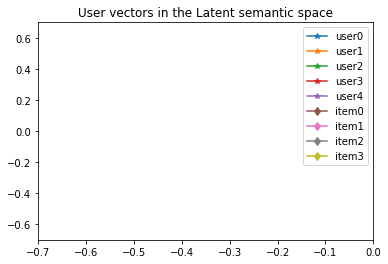

In [52]:

%matplotlib inline
from pylab import *

#Plot all the users
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()